# Answering business questions using SQL queries
Data about the fictional "Chinook Music Store" is located in a file called chinook.db, a locally stored SQL database. The goal of this project is to answer questions pertaining to this data, by using the power of sqlite to perform complex SQL queries easily. The schema of the database is shown here:

![Chinook music store database schema](chinook-schema.svg)

## Setting up helper functions
We'll use sqlite to interact with the SQL database, and pandas to store the results of the queries. First, let's set up some helper functions to make running queries and commands easier, and to explore the tables in the database.

In [3]:
import sqlite3
import pandas as pd

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view');"
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Question 1
Four new artists are available to be sold on the store. Which should be contracted with? We are interested in selling in the USA, and therefore want to identify the genres that sell best there. The four artists and their genres are:
* Regal, Hip-Hop
* Red Tone, Punk
* Meteor and the Girls, Pop
* Slim Jim Bites, Blues

To find out which genres sell best in the USA, we have to join the tables corresponding to invoices (individual sales), customers (to identify the USA ones and filter accordingly), invoice lines (to account for all the tracks sold in a single purchase), tracks (to locate the genre id), and genres (to identify the genre name), and group up the results on the genre, and sum up the total for each. Then, we can calculate the proportion of that genre relative to all the sales.

In [8]:
query_genres = """
WITH subquery AS 
    (SELECT g.name, COUNT(*) total_sold
    FROM invoice i
    LEFT JOIN customer c ON c.customer_id = i.customer_id
    LEFT JOIN invoice_line il ON il.invoice_id = i.invoice_id
    LEFT JOIN track t ON t.track_id = il.track_id
    LEFT JOIN genre g ON g.genre_id = t.genre_id
    WHERE c.country = "USA"
    GROUP BY g.name)
SELECT *, ROUND(100*total_sold / (SELECT TOTAL(total_sold) from subquery),3) percentage_sold
FROM subquery"""
question_1 = run_query(query_genres).set_index('name')
question_1

,total_sold,percentage_sold
name,,
Alternative,35,3.330
Alternative & Punk,130,12.369
Blues,36,3.425
Classical,4,0.381
Easy Listening,13,1.237
Electronica/Dance,5,0.476
Heavy Metal,3,0.285
Hip Hop/Rap,20,1.903
Jazz,14,1.332


Let's visualize these results in a bar plot.

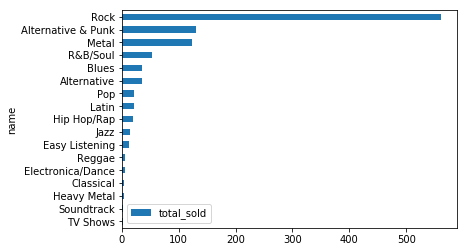

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
question_1.sort_values('total_sold').plot.barh(y='total_sold')

Rock, alternative, and metal are the vast majority of sales. Therefore, the priority should be to add Red Tone, a punk band, to the store.

## Question 2
Each customer is linked with a employee when they first make a purchase. Is any employee performing better or worse?

To do this, we sum the total dollar amount of sales corresponding to each agent, by joining the invoices to the customer and employee tables, which give us some additional info such as country, age, and time in the company.

In [15]:
query_agent = """
SELECT
    e.first_name || " " || e.last_name employee_name,
    e.country,
    e.birthdate,
    e.hire_date,
    TOTAL(i.total) total_sales
FROM invoice i
INNER JOIN customer c ON c.customer_id = i.customer_id
INNER JOIN employee e ON e.employee_id = c.support_rep_id
GROUP BY 1
"""
question_2 = run_query(query_agent).set_index('employee_name')
question_2

,country,birthdate,hire_date,total_sales
employee_name,,,,
Jane Peacock,Canada,1973-08-29 00:00:00,2017-04-01 00:00:00,1731.51
Margaret Park,Canada,1947-09-19 00:00:00,2017-05-03 00:00:00,1584.00
Steve Johnson,Canada,1965-03-03 00:00:00,2017-10-17 00:00:00,1393.92


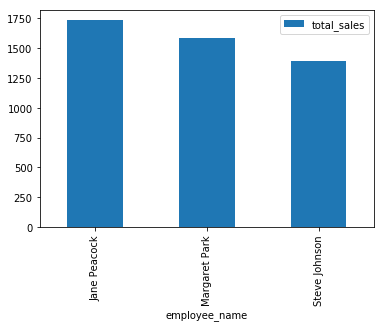

In [17]:
question_2.plot.bar()

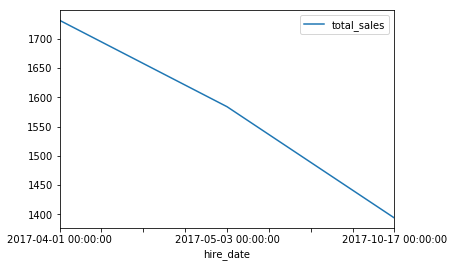

In [18]:
question_2.plot(x='hire_date',y='total_sales')

The three employees dont have too different sales results, but the one hired earliest as the most sales, as expected. No employee is performing much better or worse than any other.

## Question 3
To identify the best markets for potential future growth, we want to visualize, for each country:
* total number of customers
* total value of sales
* average money spent per customer
* average order value

Countries with just one customer will be regrouped as "Other". To do this, the SQL query is quite complex:
* First, join invoice and customer, to add up sale and distinct customer totals while grouping by country
* add a column in which countries with 1 total customer are labelled as Other
* group the data by this new column and add up the totals once again
* include a sorting column that only takes the value 1 for the Other countries, forcing it to take last place when sorting
* calculate the averages

In [48]:
query_country = """
WITH all_countries AS
    (SELECT
        c.country,
        COUNT(DISTINCT(c.customer_id)) total_customers,
        TOTAL(i.total) total_sales,
        COUNT(DISTINCT(i.invoice_id)) total_invoices
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY 1),
    
    regroup AS
    (SELECT
        CASE
            WHEN total_customers = 1 THEN "Other"
            ELSE country
        END 
        AS country_regrouped,
        a.country,
        a.total_customers,
        a.total_sales,
        a.total_invoices
    FROM all_countries a),
    
    add_up AS
    (SELECT 
        country_regrouped,
        SUM(total_customers) total_customers,
        SUM(total_sales) total_sales,
        CASE
            WHEN country_regrouped = 'Other' THEN 1
            ELSE 0
        END as sorting_col,
        SUM(total_invoices) total_invoices
    FROM regroup
    GROUP BY 1
    ORDER BY 3 DESC
    )    

SELECT 
    country_regrouped country,
    total_customers,
    total_sales,
    total_invoices,
    total_sales / total_customers avg_money_spent,
    total_sales / total_invoices avg_order_value
FROM add_up
ORDER BY sorting_col

"""
question_3 = run_query(query_country).set_index('country')
question_3

,total_customers,total_sales,total_invoices,avg_money_spent,avg_order_value
country,,,,,
USA,13,1040.49,131,80.037692,7.942672
Canada,8,535.59,76,66.948750,7.047237
Brazil,5,427.68,61,85.536000,7.011148
France,5,389.07,50,77.814000,7.781400
Germany,4,334.62,41,83.655000,8.161463
Czech Republic,2,273.24,30,136.620000,9.108000
United Kingdom,3,245.52,28,81.840000,8.768571
Portugal,2,185.13,29,92.565000,6.383793
India,2,183.15,21,91.575000,8.721429


Text(0.5, 1.0, 'Customers per Country')

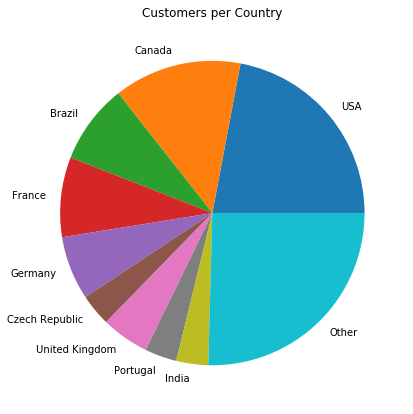

In [34]:
question_3.plot.pie(y='total_customers', legend=None, figsize=(7, 7))
plt.ylabel('')
plt.title('Customers per Country')

Text(0.5, 1.0, 'Total Sales per Country')

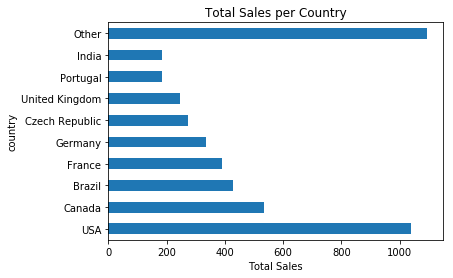

In [45]:
question_3.plot.barh(y = 'total_sales', legend=None).set_xlabel('Total Sales')
plt.title('Total Sales per Country')

Text(0.5, 1.0, 'Avg Money Spent per Customer per Country')

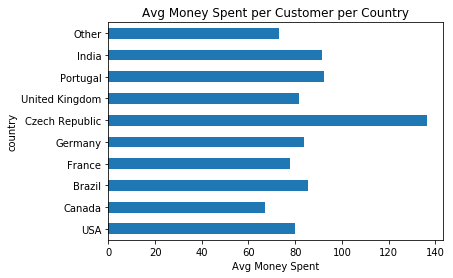

In [44]:
question_3.plot.barh(y = 'avg_money_spent', legend=None).set_xlabel('Avg Money Spent')
plt.title('Avg Money Spent per Customer per Country')

Text(0.5, 1.0, 'Avg Order Value per Country')

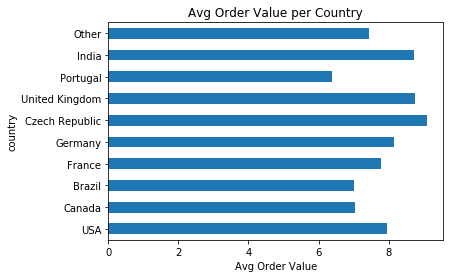

In [50]:
question_3.plot.barh(y = 'avg_order_value', legend=None).set_xlabel('Avg Order Value')
plt.title('Avg Order Value per Country')

It seems that the Czech Republic offers strong potential for growth, as it has a small number of customers still, but high average expenditure and order value.

## Question 4
For the last question, we want to find out if purchases are made as full albums or individual tracks. If they are not mostly full albums, it might make sense to buy and sell only top tracks on each album, rather than carry less well performing tracks.

To do this, the SQL query:
* joins the invoice, track, and album tables, and groups them by invoice id, selecting one single album from which a song exists in that invoice (the one with the minimum id, but maximum would work just as well)
* compares all the tracks corresponding to that album id in the track table to all the tracks in the invoice line table where the invoice id is the same as the invoice id in the grouping done above, to determine if the invoice corresponds to a full album purchase. This comparison is done using the EXCEPT function, and therefore must be done both ways (if there are more tracks in the invoice, or if there are more tracks in the album, then it is not a full album purchase)
* calculates the total and average of album and non album purchases

In [51]:
query_purchase = """
WITH invoice_first_album AS
    (SELECT
        il.invoice_id,
        MIN(al.album_id) invoice_album
    FROM invoice_line il
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN album al ON al.album_id = t.album_id
    GROUP BY invoice_id
    ),
    
    comparison AS
    (SELECT
        ifa.invoice_id,
        CASE
            WHEN (
            ((
                    SELECT track_id
                    FROM track
                    WHERE album_id = ifa.invoice_album
                EXCEPT
                    SELECT track_id
                     FROM invoice_line
                     WHERE invoice_id = ifa.invoice_id
                ) 
                IS NULL)
            AND
            ((
                SELECT track_id
                 FROM invoice_line
                 WHERE invoice_id = ifa.invoice_id
                     EXCEPT
                 SELECT track_id
                    FROM track
                    WHERE album_id = ifa.invoice_album
                ) 
                IS NULL))
                THEN "yes, album"
                ELSE "not album"
        END AS album_purchase
    FROM invoice_first_album ifa)

SELECT 
    album_purchase,
    COUNT(album_purchase) total,
    CAST(COUNT(album_purchase) AS FLOAT) / (SELECT COUNT(*) FROM comparison) percentage
FROM comparison
GROUP BY 1"""
run_query(query_purchase)

,album_purchase,total,percentage
0,not album,500,0.814332
1,"yes, album",114,0.185668


As the numbers show, most sales are not full albums, and therefore it might be a wise business decision to no longer buy full albums to sell them, but only focus on top performing tracks. However, this might generate negative customer responses, and must not be taken lightly.

## Conclusion
Using sqlite, we were able to answer complex business questions by querying a SQL database through python, and feed the results directly into pandas visualizations.